# Intermediate: Classifying stellar flares with *stella*

This notebook tutorial demonstrates how to determine whether or not a TESS light curve contains a stellar flare using the *stella* package. AS: I've commented out code that I may use later but doesn't strictly contribute to the current flow!

# Learning objectives
- Understand Basic structure of neural networks and how they can be applied to astronomy
- Be able to determine the quality of a neural network's training
- Understand how stellar flares can be identified in light curves 

***

## Introduction

Stellar flares touch disparate corners of astrophysics. From the perspective of studying exoplanets, they may control atmospheric evolution and erosion; from the perspective of studying stars, they provide insight into stellar interiors and magnetic fields (cite a bunch)  

The <a href=https://archive.stsci.edu/missions-and-data/tess>TESS mission</a>, with its relatively long-duration observations (28 days at a time) at a relatively short cadence (as low as 20 seconds), is well suited for searches of time-dependent stellar effects such as flares. A number of studies have used the observatory to detect flares (e.g., <a href=https://iopscience.iop.org/article/10.3847/1538-3881/abac0a/meta>Feinstein et al. 2020</a>, <a href=https://iopscience.iop.org/article/10.3847/1538-3881/ab5d3a/meta>Günther et al. 2020</a>)  

This notebook will explore stellar flare classification with neural networks. We will hew closely to the <a href=https://spacetelescope.github.io/hellouniverse/intro.html>Hello Universe example</a>, which makes use of the Stella code developed in <a href=https://iopscience.iop.org/article/10.3847/1538-3881/abac0a/meta>Feinstein et al. 2020</a>.

## Import Statements

* **numpy** is used for array manipulation.
* **tarfile** is used for unpacking datasets.

* **astropy.io.fits** allows us to interact with the FITS files.
* **astropy.utils.data.download_data** is used to download the data at the location specified by a URL.
* **matplotlib.pyplot** is used to display images and plot datasets.
* **stella** is used to manipulate CNNs for classifying stellar flares.
* **keras** is used to manuipulate CNN architecture.
* **sklearn** is a machine learning library with helpful utility functions for deep learning.
* **lightkurve** allows us to easily interact with TESS light curves.

Note — importing some of these packages (such as tensorflow) can take a minute or more!

# Part 1: installation
(will fill in once I double-check that a simpler conda approach doesn't work out of the box!)

In [1]:
# arrays
import numpy as np

# unpacking files 
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

2023-07-19 14:23:37.594819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 14:23:37.736294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-19 14:23:37.736331: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-19 14:23:38.537472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Next, we'll need to install the `stella` package. To do so, we'll use a `conda` command to install the package directly from its <a href=https://github.com/afeinstein20/stella>GitHub repository.</a> 

In [2]:
conda run pip install git+https://github.com/afeinstein20/stella


  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-vr7mou0h
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-vr7mou0h


Note: you may need to restart the kernel to use updated packages.


In [3]:
import stella

# Part 2: Science

## Downloading the *stella* data
Classification algorithms such as neural networks require large datasets to "learn" what they're looking for (we'll describe this in further detail in later sections). Luckily, the authors of the *stella* package have curated a set of TESS light curves that do and do not (as far as have been detected) exhibit flares. We'll use this dataset to help our neural network find patterns in data, via a process known as "training."

First, we identify where the file is hosted on STScI servers.

In [4]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'

Next, we download and open the file. setting ``cache=True`` means that the file won't be downloaded again if it's already been downloaded before.

In [5]:
file = tarfile.open(download_file(file_url, cache=True))

Next, we extract the contents of the file, placing the folder within in the current directory — the '.' directory.

In [6]:
file.extractall('.')
file.close() # be sure to close files when you're finished with them!

At this point, the data is downloaded and accessible to our server instance. Let's use ``stella`` to construct a ``FlareDataSet`` object with the data that we have.

In [7]:
data_dir = './hellouniverse_stella_500/'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 324.16it/s]


502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



What is this ``ds`` object, and what did the function spit out? ``FlareDataSet``s are essentially reformatted collections of training datasets for neural networks, with the data arrays shaped for neural network inputs and labeled by whether or not they contain a flare. These labels are provided by the ``catalog``, which we specify in the ``FlareDataSet`` initialization.

The text printed to the notebook first lets us know that the files are being read in (as intended) then provides a progress bar (courtesy of the `tqdm` package). Then, we're given the statistics of the dataset: that 502 light curves contain flares, and 1342 do not. The mistmatch between lightcurves with and without flares is known as a ``class imbalance''. We'll explore in an exercise how the class imbalance impacts the neural network performance.

Now, let's clean up this dataset a little bit and plot it.

In [8]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    """
    Determine indices of files without NaNs.
    
    Inputs
    ------
        :input_data: data that will be passed to CNN (array-like)
        
    Outputs
    -------
        :idx: indices without NaNs. (list)
    """

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

Now, let's plot a subset of the data. Let's choose random ones. Try executing the next cell a few times in a row — you'll get different plots each time!

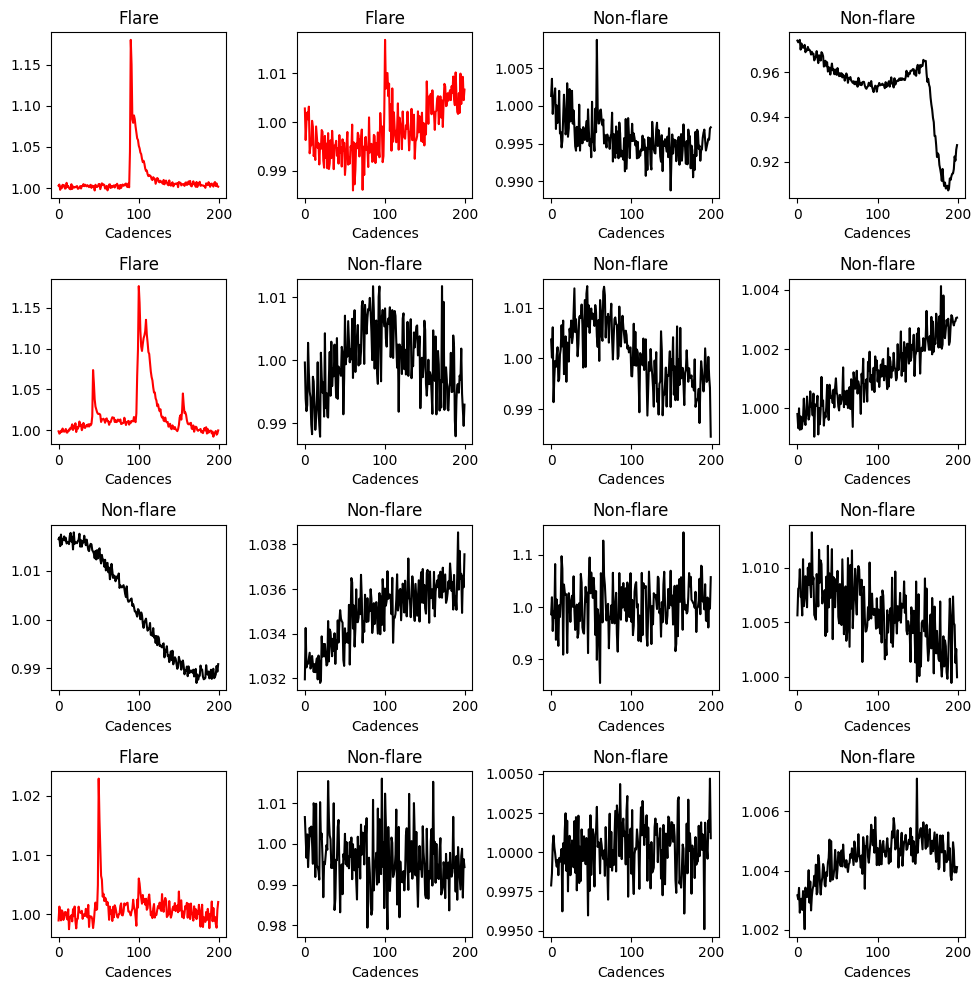

In [9]:
# select random image indices:
example_ids = np.random.choice(len(ds.train_labels), 16)

# pull the lightcurves and labels for these selections
example_lightcurves = [ds.train_data[j] for j in example_ids]
example_labels = [ds.train_labels[j] for j in example_ids]


# initialize your figure
fig = plt.figure(figsize=(10, 10))


# create two dictionaries with the same keys mapping to corresponding colors and flare property
colors = {1: 'r', 0: 'k'}
titles = {1: 'Flare', 0: 'Non-flare'}

# loop through the randomly selected images and plot with labels. The red ones indeed have flares!
for i in range(len(example_ids)):
    plt.subplot(4, 4, i + 1)
    plt.plot(example_lightcurves[i], color=colors[example_labels[i]])
    plt.title(titles[example_labels[i]])
    plt.xlabel('Cadences')
    
plt.tight_layout()
plt.show()

It seems like we have our dataset, and we're flagging things that look like flares. Awesome!

## Training our neural network

### What is a classifier?

Our final goal is to take in a light curve and figure out whether it has a flare or not. We have a large labeled dataset — a list of light curves and the knowledge of whether or not they contain flares — but these examples alone will not be helpful enough to quantitatively classify a new light curve. Our eyes can sort of do the job for us, because flares have a physically motivated shape to them. But, ideally, we want something better than human eyes: something reproducible, something fast, something quantitative, something understandable.

Thus enters a set of algorithms known as "classifiers." These programs take in data, and spit out a "yes/no" answer. In our case, a classifier would indeed be able to tell us whether or not a lightcurve contains a flare — and perhaps even how confident the algorithm is in its answer.


### What is a neural network?

Neural networks are a specific type of of program that can be used to solve classification problems. Their namesake is the neuron in a brain, after which neural networks are loosely based. At each layer of a neural network, each neuron receives the weighted output of neurons from the previous layer. It then combines those outputs non-linearly and sends its output to the next layer. This approach allows neural networks to approximate complex and non-linear functions quite well.

But approximating functions isn't enough — we need our neural network to figure out what these functions *are*. Doing so involves training, or the act of tuning the weights between neurons mentioned above. Various algorithms (such as <a href=https://www.ibm.com/topics/gradient-descent>gradient descent</a>) have been devised to efficiently and accurately train neural networks.

A <a href=https://www.geeksforgeeks.org/introduction-convolution-neural-network/>convolutional neural network</a> is a type of neural network that includes a convolutional layer. This special type of layer performs, as its name implies, a *convolution*. By doing so, the layer can combine information from neighboring features in a dataset. For instance, it can combine information from two neighboring pixels in an image — or, in our case, two neighboring time stamps in a light curve.

Please note that this is not an exhaustive explanation of neural networks — and feel free to check out the linked resources at the bottom of this notebook for further information.

Neural nets require some weight initialization. We don't know ahead of time what the weights should be, so they're defined randomly. Setting a *random seed* for our program ensures that while it is random, it is *reproducibly* random.

In [10]:
# set the random seed
seed = 42
np.random.seed(seed)

We next want to set the filter size of our CNN — that is, how many adjacent pixels it considers.

In [11]:
filter1 = 16
filter2 = 64

Next, we should decide how many neurons to include per layer. Let's try 128 ndoes.

In [12]:
dense = 128

After setting the number of neuraons, we set the value for our dropout layers. These layers can help prevent overfitting by killing off some weights to prevent over-complex function representations.

In [13]:
dropout = 0.1 # let's keep this low for now.

Now, we can set the neural net architecture and define our model!

In [14]:
data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

# set up the network
x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)


# instantiate the network
cnn = Model(inputs=x_in, outputs=y_out)

2023-07-19 14:23:57.820302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-19 14:23:57.820338: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-19 14:23:57.820370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-asavel-40umd-2eedu): /proc/driver/nvidia/version does not exist
2023-07-19 14:23:57.820595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Next, we compile our model. We include arguments that specify how to train the network (the `optimizer`), the quantities to track during training for output (`fit_metrics`), an  how to evlauate whether the model is performing well during training (the `loss`).

In [15]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 7)            119       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 7)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 7)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 3)            1347      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 3)            0         
 1D)                                                         

That's a lot of parameters! We're starting to get a sense for why neural networks are a powerful technique. With this many parameters, though, we may begin to worry that we're <a href=https://www.ibm.com/topics/overfitting>overfitting</a>. Loosely, "overfitting" refers to the idea that our model is too highly tuned to the specific dataset. This means that it's not actually "learning" the underlying trend, and it will likely not perform well on a second set of similar data. Thankfully, we can perform some tests as we go to ensure that our model is not overfitting our data.


Now, with our model all set up, we can actually train it on the dataset. We'll have to set some details of the training stage now. We begin with the number of epochs. During each epoch, the neural network is trained on all the data. Some terminology:

- a *sample* is a single piece of your training set. In our case, it's a light curve.
- the *batch size* is how many samples the algorithm looks at before deciding to update its parameters.
- the *epoch number* is the number of times that the algorithm works through the whole training set. More epochs means the algorithm "sees" the data more times in total — meaning that it has more chances to adjust itself to better predict the expected results.

In [16]:
nb_epoch = 100 # the model sees the dataset 100 times
batch_size = 64 # 64 light curves are seen before the model updates itself

# between each epoch, present the data in a different order. This can help prevent overfitting or order bias.
shuffle = True 

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=False) # setting verbose=True produces a lot of output. Feel free to change this if you're curious!

Let's save our dataset before proceeding so that we don't have to retrain the whole model if something goes wrong.

In [17]:
# save the model to file
cnn_file = 'initial_flare_model_small_dataset.h5'
cnn.save(cnn_file)


## Training, testing, and validation data
One neat thing about *stella* is that it automatically partitions the light curves into categories known as "training", "testing", and "validation" data. The training set contains all the data that your machine learning model will use to actually "learn". The the validation set includes data that the model is evaluated against at the end of each epoch, but that doesn't go directly into the training itself. The testing data is a separate set of data that's used at the end of trianing altogether.

Text(0, 0.5, 'Loss')

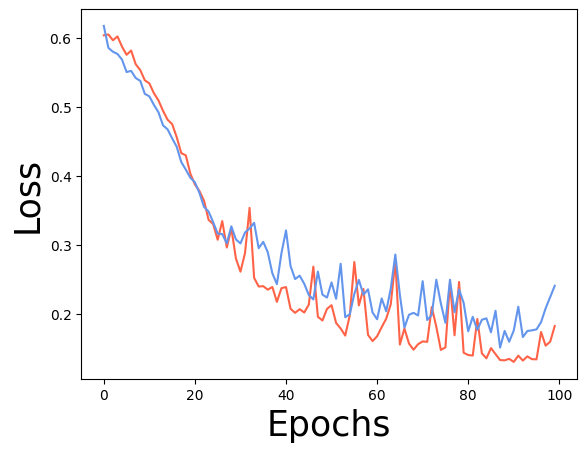

In [18]:
plt.plot(history.history['val_loss'], color='tomato')
plt.plot(history.history['loss'], color='cornflowerblue')

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Loss', fontsize=25)

Text(0, 0.5, 'Accuracy')

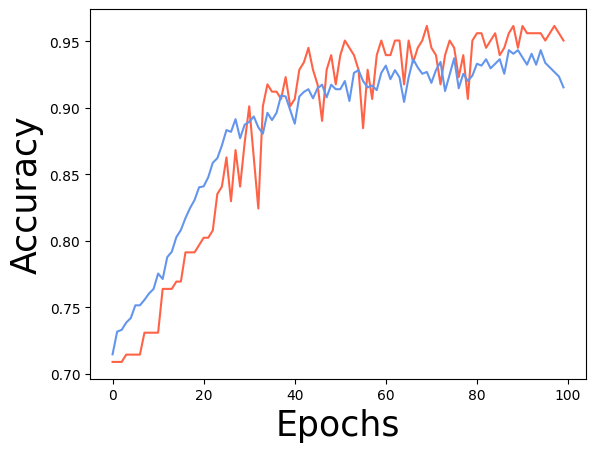

In [19]:
plt.plot(history.history['val_accuracy'], color='tomato',label='Validation')
plt.plot(history.history['accuracy'], color='cornflowerblue', label='Accuracy')

plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)

Interesting! Seems like these metrics (both testing and validation accuracy) are noisy and still improving with further epochs. This indicates that we are not yet overfitting — and perhaps that we can even improve the model more with further training. 

## The confusion matrix

At each training epoch, we're told how the model's performing — its loss, its accuracy, its validation set loss, and its validation set accuracy. These numbers are great to compare against one another (especially when iterating models), but we'd like a global statistic for evaluating our models that's straightforward to understand. That's where the confusion matrix comes in.

The confusion matrix tells us: of the flares we're trying to classify, how many of the flares did we correctly identify (true positives; top left), how many did we not identify (false negatives, top right), how many non-flares did we classify as flares (false positives; bottom left), and how many non-flares did we correctly identify (true negatives; bottom right). The rows in a confusion matrix add to 100%. The best-case scenario maximizes the top left and bottom right while minimizing the top right and bottom left. We calculate the confusion matrix with respect to the test data — again, a set of light curves that the model has never seen before.

In [20]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    """
    Plots a confusion matrix based on a CNN's predictions.
    
    Inputs
    ------
        :cnn: Convolutional neural network, previously trained to classify flares. (keras Functional object)
        :input_data: data against which the cnn will be tested.
        :input_labels: labels (whether or not input data contains flares) against which the cnn will be tested.
        
    Outputs
    --------
        None
        
    Side effects
    ------------
        Plots confusion matrix.
    """
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center",color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

6/6 [==============================] - 0s 4ms/step


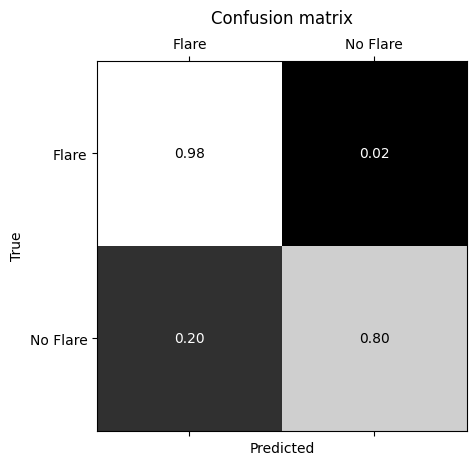

In [21]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


This looks pretty good! More than 95% of the true flares were found by our classifier, and less than 20% of the light curves that are not known to exhibit flares were not flagged as flaring.

## Trying the algorithm on real data
We have an algothithm that works well enough. Now, let's apply it to real data.

In [24]:
# gather a list of TIC (Tess Input Catalog) identification numbers.

ticids = ['120461526', '278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()
    lcs.append(lc)

In [25]:
# quality checks: see if there are non-finite numbers in the light curve
for lc in lcs:
    if len(lc)>0: lc = lc[0] 
    if not np.all(np.isfinite(lc.flux)):
        print('bad!')

In [26]:
# load the CNN using `stella`
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


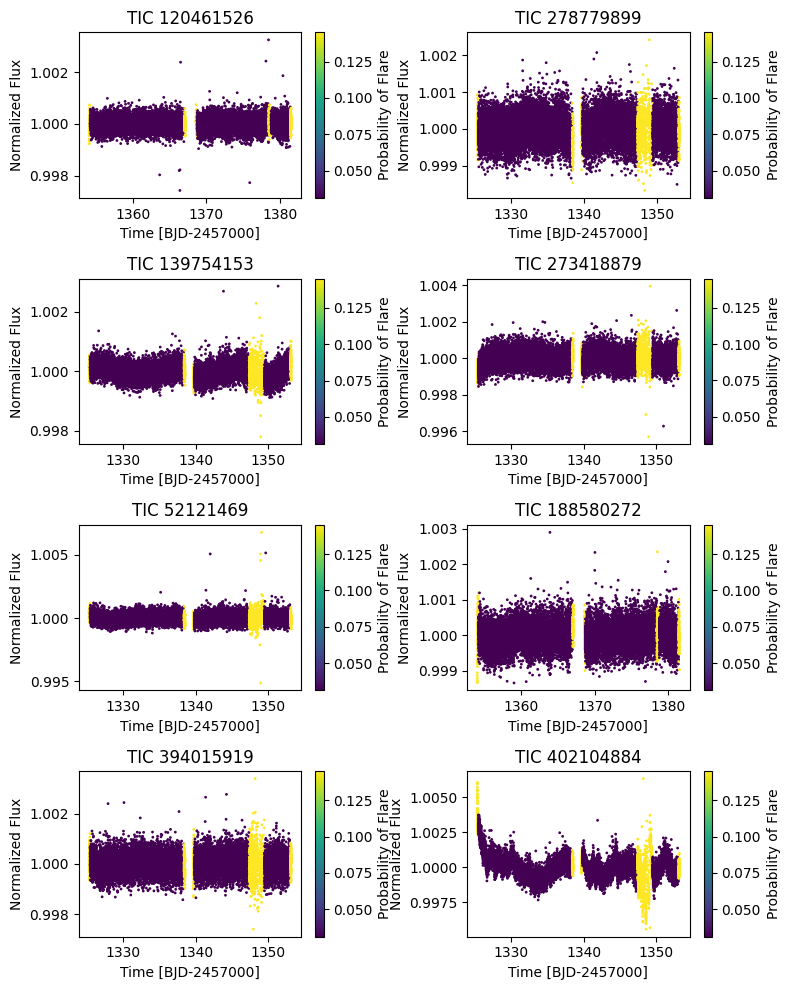

In [28]:
fig = plt.figure(0, [8, 10])

for i, lc in enumerate(lcs):
    
    # pull out on the first light curve in each set, if more than one exist
    if len(lc)>0: lc = lc[0]
        
    # predict the flare probability light cuvey for the input data using `stella` 
    # (which applies the necessary pre-processing to the data for input to the CNN)
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ax = fig.add_subplot(4,2,i+1)
    im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
    
    plt.colorbar(im, ax=ax, label='Probability of Flare')
    ax.set_xlabel('Time [BJD-2457000]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title('TIC {}'.format(lc.targetid));
plt.tight_layout()
plt.show()

# Exercises
- You may have arrived at a false positive rate (bottom left corner of the confusion matrix) of roughly 30%. Improve this rate first using more complex model architecture (more layers, denser layers)
- Now do the same, but by using more data. Which approach gives you a "better" confusion matrix? Which approach is more prone to overfitting? How does the class imbalance affect both overfitting and the confusion matrix?
- You may have noticed that this algorithm picks out regions near data gaps as having high probabilities of having flares, even if by eye they seem to not be flaring. This is more of a bug than a feature, and addressing it would likely be difficult to do in the context of a CNN. Rather than hack the model itself, we can refine our final predictions by masking those that make sense. That is, to arrive at cleaner results, we can simply reject results that lie too close to data gaps. Do so, and see how your results change.
- Given what we know about flares, why might CNNs be a good architecture choice for detecting / classifying them?


# Resources
- <a href=https://www.ibm.com/topics/overfitting> IBM cloud on overfitting </a>
- <a href=https://www.cambridge.org/core/journals/international-astronomical-union-colloquium/article/review-of-stellar-flares-and-their-characteristics/F23B5B96E8450CD685D00988C0579B8C> Stellar flares review </a>
- <a href=https://github.com/afeinstein20/stella> stella GitHub repository </a>
- <a href=https://adina.feinste.in/stella/> stella documentation </a>
- <a href=https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414> high-level article on neural networks </a>
- <a href=https://www.quantamagazine.org/how-artificial-intelligence-is-changing-science-20190311/> Quanta article on AI in science </a>
- <a href=https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5> article on confusion matrices</a>